In [1]:
from mpi4py import MPI
from dolfinx import mesh
from dolfinx.fem import FunctionSpace
from dolfinx import fem
import numpy as np
import ufl
from dolfinx import default_scalar_type
from dolfinx.fem.petsc import LinearProblem
import pyvista
from dolfinx import plot
from dolfinx.mesh import (CellType, compute_midpoints, create_unit_cube,
                          create_unit_square, meshtags)

In [2]:
#create a rectangle mesh
x0 = 0
x1  = 4
y0 = 0
y1 = 2
nx=4
ny=2
domain = mesh.create_rectangle(MPI.COMM_WORLD, [[x0, y0],[x1, y1]], [nx, ny])
# Create facet to cell connectivity required to determine boundary facets
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

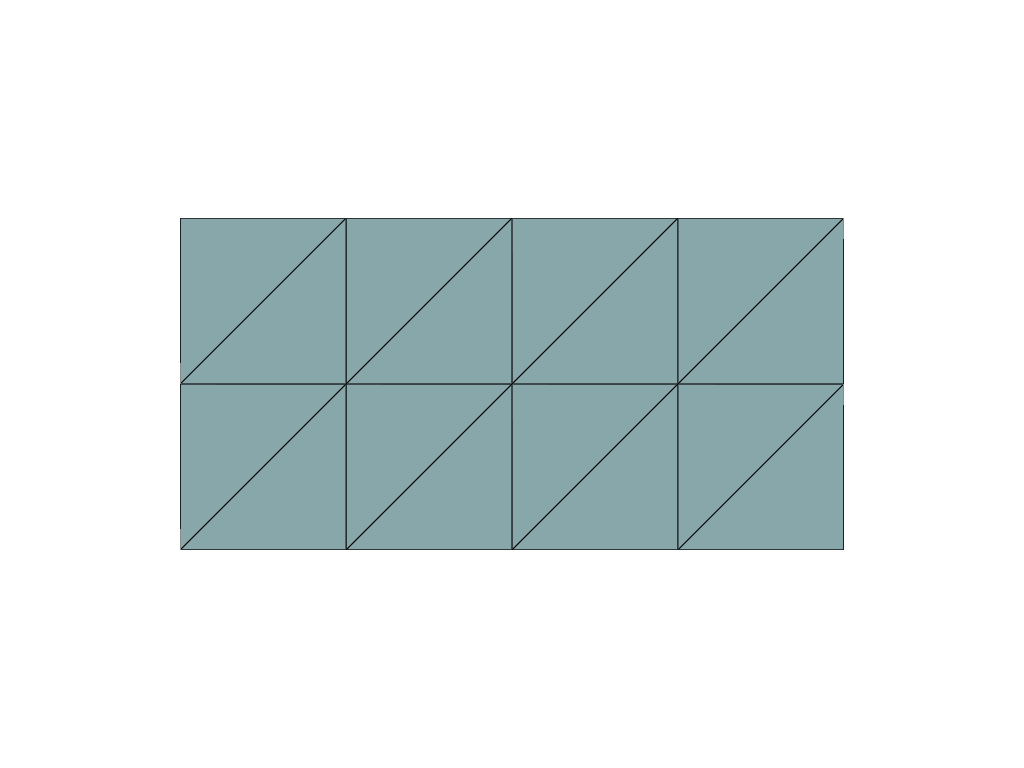

In [3]:
#Plot mesh
#Plotting is what we need
pyvista.start_xvfb()
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

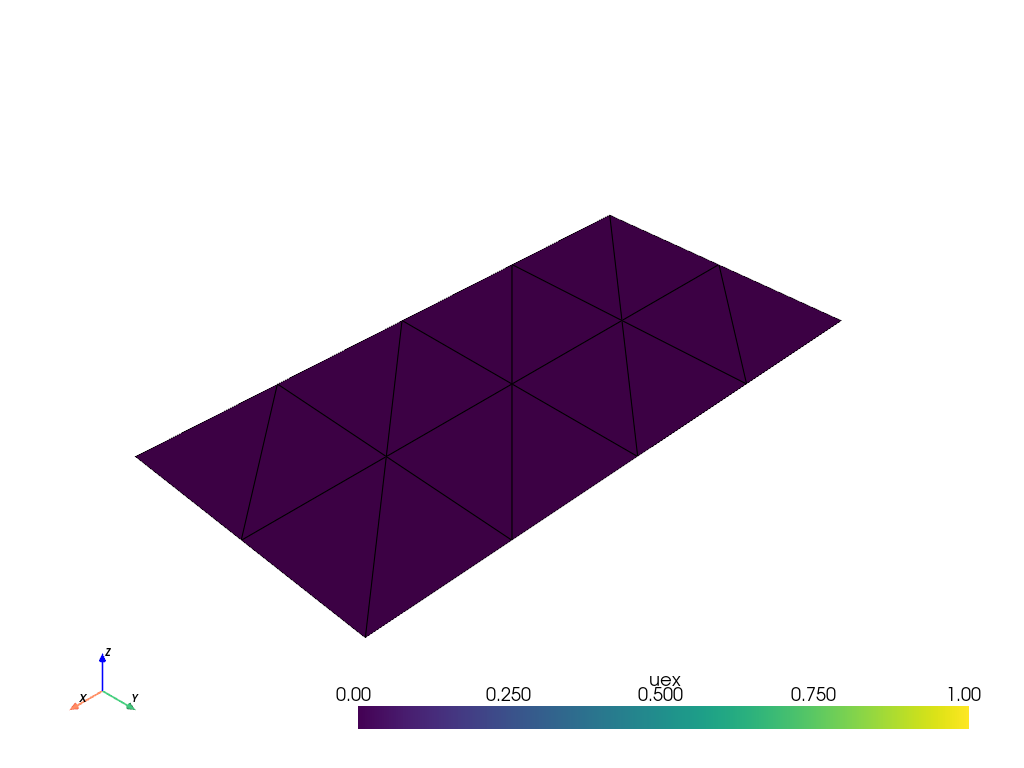

In [4]:

gdim=2
V = fem.FunctionSpace(domain,("Lagrange", 1))
V2 = fem.FunctionSpace(domain, ("DG", 0))
uex = fem.Function(V2)
uex.interpolate(lambda x: x[0]>5000)

u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
#u_grid.point_data["u"] = uh.x.array.real
#u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)



u_grid.cell_data["uex"] = uex.vector.array
u_grid.set_active_scalars("uex")

p = pyvista.Plotter()
p.add_mesh(u_grid,show_edges=True)
p.show_axes()
if not pyvista.OFF_SCREEN:
    p.show()
else:
    stress_figure = p.screenshot(f"stresses.png")



2


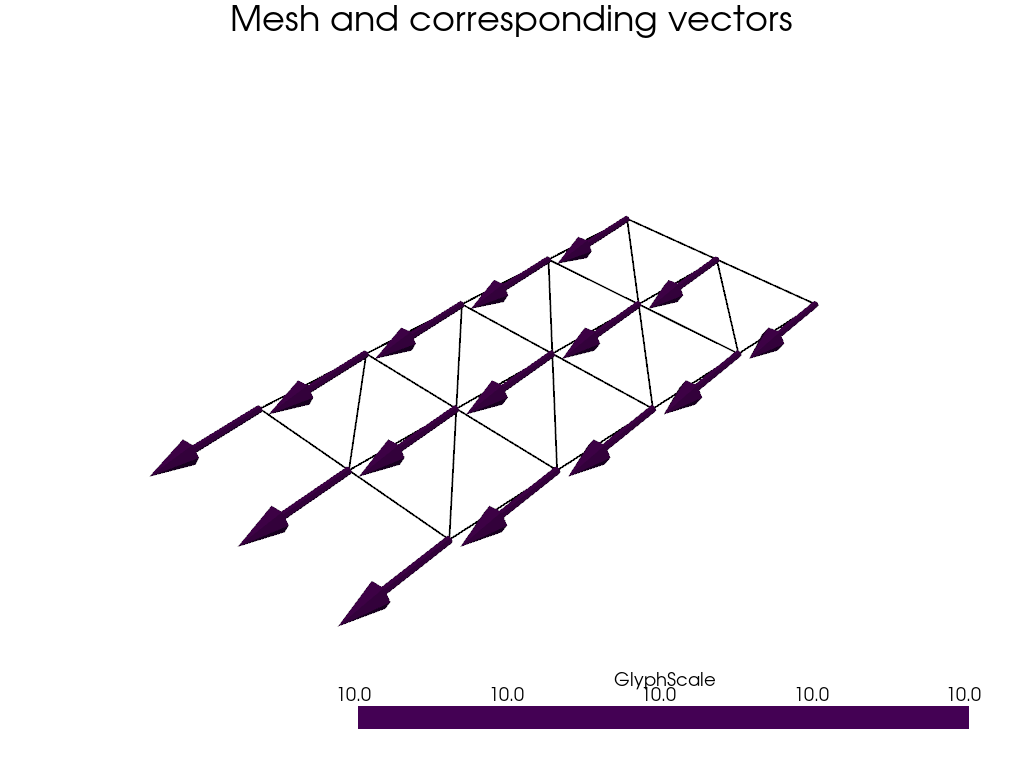

In [5]:
plotter = pyvista.Plotter()
plotter.add_text("Mesh and corresponding vectors",
                     position="upper_edge", font_size=14, color="black")

# Next, we create a pyvista.UnstructuredGrid based on the mesh
pyvista_cells, cell_types, x = plot.vtk_mesh(domain)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, x)

# Add this grid (as a wireframe) to the plotter
plotter.add_mesh(grid, style="wireframe", line_width=2, color="black")

#now create a vector function that is DG P0
gdim = domain.geometry.dim
print(gdim)
V0 = fem.FunctionSpace(domain, ("Discontinuous Lagrange", 0, (gdim,)))
u0 = fem.Function(V0, dtype=np.float64)
u0.interpolate(lambda x: (10*(x[0]<5000),1+0*x[0]))

#For plotting only, we must use order 1
V1 = fem.functionspace(domain, ("Discontinuous Lagrange", 1, (gdim,)))
u_n = fem.Function(V1, dtype=np.float64)
u_n.interpolate(u0)

cells, cell_types, x = plot.vtk_mesh(V1)
grid = pyvista.UnstructuredGrid(cells, cell_types, x)

vals = np.zeros((x.shape[0],3))
vals[:,:gdim]= u_n.x.array.reshape(x.shape[0], gdim)

grid.point_data["u"] = vals
glyphs = grid.glyph(orient="u", factor=0.1)



# We add in the glyphs corresponding to the plotter
plotter.add_mesh(glyphs)

# Save as png if we are using a container with no rendering
if pyvista.OFF_SCREEN:
    plotter.screenshot("3D_wireframe_with_vectors.png", transparent_background=transparent,
                           window_size=[figsize, figsize])
else:
    plotter.show()




In [6]:
#need to be able to connect cell -> dof
#what node #s for each cell
meshconnectivity=domain.geometry.dofmap
#node locations
nodes=domain.geometry.x

#Print nodes and cells
print(nodes)
#Centroids of each cell
DG0_DOFS=V0.tabulate_dof_coordinates()
#The location of each dof
DG1_DOFS=V1.tabulate_dof_coordinates()
print(nodes[meshconnectivity])
#print(DG1_DOFS[:12,:])

[[3. 0. 0.]
 [4. 0. 0.]
 [4. 1. 0.]
 [3. 1. 0.]
 [2. 0. 0.]
 [4. 2. 0.]
 [2. 1. 0.]
 [3. 2. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [2. 2. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [1. 2. 0.]
 [0. 2. 0.]]
[[[3. 0. 0.]
  [4. 0. 0.]
  [4. 1. 0.]]

 [[3. 0. 0.]
  [3. 1. 0.]
  [4. 1. 0.]]

 [[2. 0. 0.]
  [3. 0. 0.]
  [3. 1. 0.]]

 [[3. 1. 0.]
  [4. 1. 0.]
  [4. 2. 0.]]

 [[2. 0. 0.]
  [2. 1. 0.]
  [3. 1. 0.]]

 [[3. 1. 0.]
  [3. 2. 0.]
  [4. 2. 0.]]

 [[1. 0. 0.]
  [2. 0. 0.]
  [2. 1. 0.]]

 [[2. 1. 0.]
  [3. 1. 0.]
  [3. 2. 0.]]

 [[1. 0. 0.]
  [1. 1. 0.]
  [2. 1. 0.]]

 [[2. 1. 0.]
  [2. 2. 0.]
  [3. 2. 0.]]

 [[0. 0. 0.]
  [1. 0. 0.]
  [1. 1. 0.]]

 [[1. 1. 0.]
  [2. 1. 0.]
  [2. 2. 0.]]

 [[0. 0. 0.]
  [0. 1. 0.]
  [1. 1. 0.]]

 [[1. 1. 0.]
  [1. 2. 0.]
  [2. 2. 0.]]

 [[0. 1. 0.]
  [1. 1. 0.]
  [1. 2. 0.]]

 [[0. 1. 0.]
  [0. 2. 0.]
  [1. 2. 0.]]]


In [7]:
#Need to precompute the angles that determine which side we go out of
#side 0 is node 0-node1
#side 1 is node 1-node2
#side 2 is node2-node0
#there are three angles in each cell that need to be stored
dim=domain.topology.dim
imap = domain.topology.index_map(dim)
ghost_cells = imap.num_ghosts
num_cells = imap.size_local + ghost_cells
nangles=np.zeros((num_cells,3))
print("# Nodes : ",nodes.shape)
print("# cells : ",num_cells)

#compute angle created by intersection of each node and centroid at each cell
temp=nodes[meshconnectivity]
vecs=temp[:,0]-DG0_DOFS
nangles[:,0] = np.arctan2(vecs[:,1],vecs[:,0])
vecs=temp[:,1]-DG0_DOFS
nangles[:,1] = np.arctan2(vecs[:,1],vecs[:,0])
vecs=temp[:,2]-DG0_DOFS
nangles[:,2] = np.arctan2(vecs[:,1],vecs[:,0])
print(nangles[:5]*180/np.pi)
nangles[nangles<0]=2*np.pi+nangles[nangles<0]
print(nangles[:5]*180/np.pi)

#Need to compute which cell is connected to what
#u0 is DG0 velocity fields
#by convention every 2 entries is one vector
#compute angle of this vector
flux_angle = np.arctan2(u0.x.array[1::2],u0.x.array[::2])
#now find the number which side the flux is pointing to 0,1,2
#we don't know ahead of time if ccw or cw so need to be careful
#we know each angle cant be off by more than 180 so check that?
#or can we know they are going in a certain direction cheaper way?
StartAngles=nangles
EndAngles=nangles[:,[1,2,0]]
#special case for when we cross across 2pi
#need to check which cells are ccw and which are cw
#use cross product??
cw_ccw_mask = np.zeros(num_cells,dtype=bool)
cw_ccw_mask = StartAngles[:,0]>EndAngles[:,0]

i_strange = StartAngles>EndAngles
print(i_strange[:5,:])

#now check which one the flux lies in
side_num=np.zeros(num_cells)




# Nodes :  (15, 3)
# cells :  16
[[-153.43494882  -45.           63.43494882]
 [-116.56505118  135.           26.56505118]
 [-153.43494882  -45.           63.43494882]
 [-153.43494882  -45.           63.43494882]
 [-116.56505118  135.           26.56505118]]
[[206.56505118 315.          63.43494882]
 [243.43494882 135.          26.56505118]
 [206.56505118 315.          63.43494882]
 [206.56505118 315.          63.43494882]
 [243.43494882 135.          26.56505118]]
[[False  True False]
 [ True  True False]
 [False  True False]
 [False  True False]
 [ True  True False]]


In [8]:
#this takes in cell # and outputs the dofs of that cell
print(V1.dofmap.cell_dofs(0))
print(V0.dofmap.cell_dofs(0))

[0 1 2]
[0]


In [9]:

print(dir(domain.topology))
print(domain.topology.connectivity(0,1))


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'cell_name', 'cell_types', 'comm', 'connectivity', 'create_connectivity', 'create_entities', 'create_entity_permutations', 'dim', 'entity_group_offsets', 'get_cell_permutation_info', 'get_facet_permutations', 'index_map', 'interprocess_facets', 'original_cell_index', 'set_connectivity', 'set_index_map']
None


In [10]:
#need to find which side neighbors which cell
'''
vertex_map = domain.topology.index_map(0)
vertex_indices = np.arange(vertex_map.size_local + vertex_map.num_ghosts)
domain.topology.create_connectivity(0, 1)
domain.topology.create_connectivity(1, 0)
vertex_to_edge = domain.topology.connectivity(0, 1)
edge_to_vertex = domain.topology.connectivity(1, 0)
for vertex in vertex_indices:
    adjacent_edges = vertex_to_edge.links(vertex)
    neighborhood = []
    for edge in adjacent_edges:
        adjacent_vertices = edge_to_vertex.links(edge)
        neighborhood.append(adjacent_vertices)
        print(neighborhood)
'''

'\nvertex_map = domain.topology.index_map(0)\nvertex_indices = np.arange(vertex_map.size_local + vertex_map.num_ghosts)\ndomain.topology.create_connectivity(0, 1)\ndomain.topology.create_connectivity(1, 0)\nvertex_to_edge = domain.topology.connectivity(0, 1)\nedge_to_vertex = domain.topology.connectivity(1, 0)\nfor vertex in vertex_indices:\n    adjacent_edges = vertex_to_edge.links(vertex)\n    neighborhood = []\n    for edge in adjacent_edges:\n        adjacent_vertices = edge_to_vertex.links(edge)\n        neighborhood.append(adjacent_vertices)\n        print(neighborhood)\n'

In [19]:

domain.topology.create_entities(2)
domain.topology.create_entities(1)
domain.topology.create_entities(0)
#print(nodes[:10])
#print(meshconnectivity[:10])
vertex_map = domain.topology.index_map(0)
facet_map = domain.topology.index_map(1)
cell_map = domain.topology.index_map(2)

vertex_indices = np.arange(vertex_map.size_local + vertex_map.num_ghosts)
cell_indices = np.arange(cell_map.size_local + cell_map.num_ghosts)
facet_indices = np.arange(facet_map.size_local + facet_map.num_ghosts)

domain.topology.create_connectivity(0, 1)
domain.topology.create_connectivity(1, 0)
domain.topology.create_connectivity(1, 2)
domain.topology.create_connectivity(2, 1)

vertex_to_edge = domain.topology.connectivity(0, 1)
edge_to_vertex = domain.topology.connectivity(1, 0)
edge_to_cell = domain.topology.connectivity(1, 2)
cell_to_edge = domain.topology.connectivity(2, 1)
cell_to_cell = domain.topology.connectivity(2, 2)


#print(cell_to_edge.links(0))
#print(cell_to_edge.links(1))
#print(cell_to_edge.links(2))

cell_indices=np.arange(cell_map.size_local + cell_map.num_ghosts)
cell_indices=np.arange(1)
adjacent_cells_list=[]

for cell_no in cell_indices:
    adjacent_edges = cell_to_edge.links(cell_no)
    #print(adjacent_edges)
    neighborhood = np.array([],dtype=np.int32)
    for edge in adjacent_edges:
        #vertices are important to compute intersections
        vertexes=edge_to_vertex.links(edge)
        print(vertexes)
        adjacent_cells = edge_to_cell.links(edge)
        print(adjacent_cells)
        neighborhood=np.append(neighborhood,adjacent_cells)
    #eliminate repeats and its own cell number
    neighborhood=np.unique(neighborhood)
    index = np.argwhere(neighborhood==cell_no)
    neighborhood = np.delete(neighborhood, index)
    adjacent_cells_list.append(neighborhood)

print(adjacent_cells_list)

#adjacent cell list gices a list which for each cell is a numpy array which tells which cells neighbor them
#we also need to keep track of which edge connects which cells
print(meshconnectivity[0])
print(nodes[meshconnectivity[0]])

#this seems to be relevant to MPI
#print(domain.topology.index_map(2).local_to_global(np.arange(20,dtype=np.int32)))

#what is this map?
#print(domain.topology.connectivity(2,1))
#domain.topology.create_entity_permutations()
#print(domain.topology.get_facet_permutations())

[1 2]
[0]
[0 2]
[0 1]
[0 1]
[0]
[array([1], dtype=int32)]
[0 1 2]
[[3. 0. 0.]
 [4. 0. 0.]
 [4. 1. 0.]]


In [45]:
'''
This is a way to loop through facets and find which cells are associated


mesh = UnitSquareMesh(4, 4)
D = mesh.topology().dim()
mesh.init(D-1,D) # Build connectivity between facets and cells
for f in facets(mesh):
    print f.index()
    print f.entities(D)
'''

'\nThis is a way to loop through facets and find which cells are associated\n\n\nmesh = UnitSquareMesh(4, 4)\nD = mesh.topology().dim()\nmesh.init(D-1,D) # Build connectivity between facets and cells\nfor f in facets(mesh):\n    print f.index()\n    print f.entities(D)\n'

In [47]:

domain.init(2,2)
mf2 = CellFunction('size_t', domain)
mf2.set_all(0)
for index in cells:
    index = index[0]
    cell = Cell(mesh, index)
    mf2.array()[cell.entities(3)] = 1
mf.array()[:] += mf2.array()

plot(mf, interactive=True)

AttributeError: 'Mesh' object has no attribute 'init'